In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import wilcoxon, rankdata

# --- rank-biserial for paired Wilcoxon ---
def rank_biserial_from_pairs(x, y):
    d = np.asarray(x) - np.asarray(y)
    d = d[d != 0]  # Wilcoxon ignores ties at zero
    if d.size == 0:
        return np.nan
    rks = rankdata(np.abs(d), method='average')
    return (rks[d > 0].sum() - rks[d < 0].sum()) / rks.sum()

n_subjects = 20
n_bars = 6
datafile = "crossvalidation_rmses.pkl"
if os.path.exists(datafile):
    with open(datafile, 'rb') as f:
        df = pickle.load(f)

# Save to cache
with open(datafile, 'wb') as f:
    pickle.dump(df, f)

df['Subject'] = [f"Subject {i+1}" for i in range(n_subjects)]
df_melt = df.melt(id_vars='Subject', var_name='Type', value_name='RMSE')

split_palette = sns.color_palette("Blues_d", 5)
cmr_color = sns.color_palette("Oranges_d", 3)[1]
palette_dict = {f"Split {i+1}": split_palette[i] for i in range(5)}
palette_dict["CMR"] = cmr_color

# Flatten all split RMSEs into one array
split_rmses = df[[f"Split {i+1}" for i in range(5)]].values.flatten()
cmr_rmses = df["CMR"].values

split_mean_rmses = df[[f"Split {i+1}" for i in range(5)]].mean(axis=1)
cmr_rmses        = df["CMR"]
stat, p = wilcoxon(split_mean_rmses, cmr_rmses, alternative="two-sided")
r_rb = rank_biserial_from_pairs(split_mean_rmses, cmr_rmses)
print(f"Wilcoxon (two-sided): W={stat:.2f}, p={p:.4g}, r_rb={r_rb:.3f}")

stat_less, p_less = wilcoxon(split_mean_rmses, cmr_rmses, alternative="less")
print(f"Wilcoxon (Split < CMR): W={stat_less:.2f}, p={p_less:.4g}, r_rb={r_rb:.3f}")

stat_greater, p_greater = wilcoxon(split_mean_rmses, cmr_rmses, alternative="greater")
print(f"Wilcoxon (Split > CMR): W={stat_greater:.2f}, p={p_greater:.4g}, r_rb={r_rb:.3f}")

Wilcoxon (two-sided): W=0.00, p=1.907e-06, r_rb=-1.000
Wilcoxon (Split < CMR): W=0.00, p=9.537e-07, r_rb=-1.000
Wilcoxon (Split > CMR): W=0.00, p=1, r_rb=-1.000


/tmp/ipykernel_136057/2534210069.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


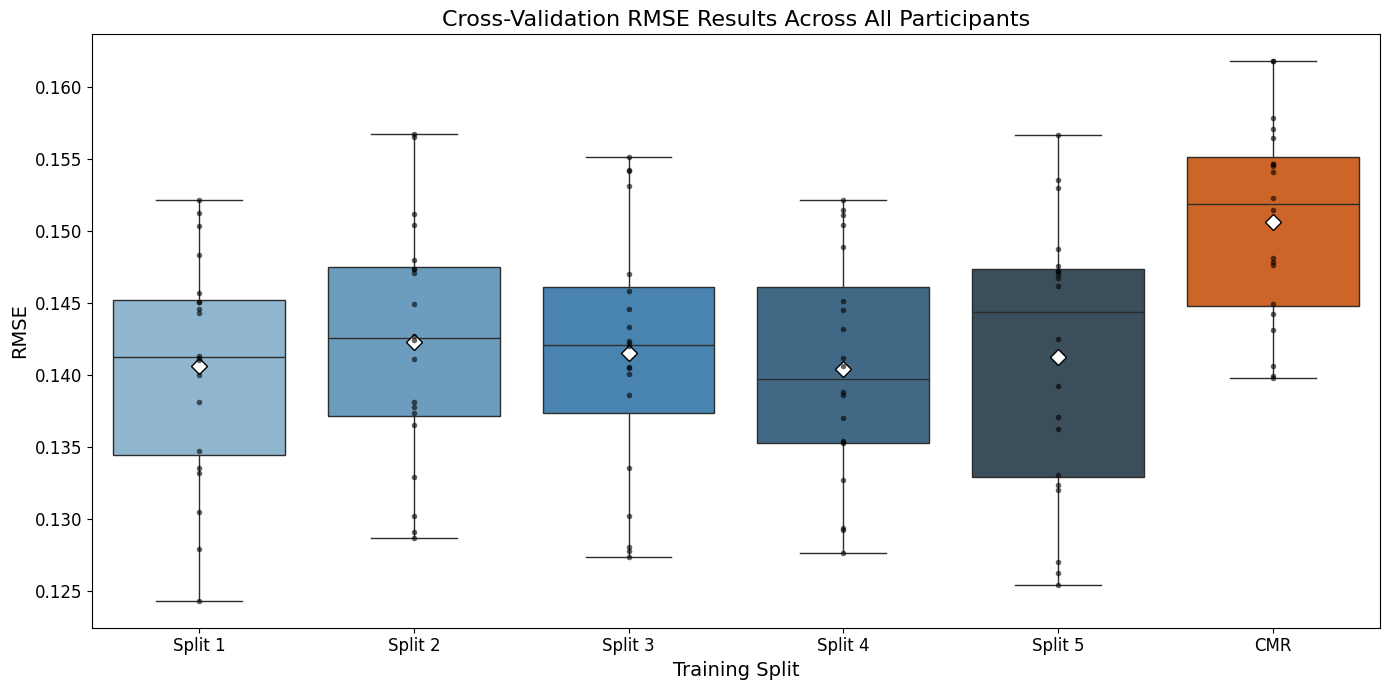

In [4]:
# order: Split 1..5 then CMR
type_order = [f"Split {i+1}" for i in range(5)] + ["CMR"]

fig, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(
    data=df_melt,
    x="Type",
    y="RMSE",
    order=type_order,
    palette=palette_dict,
    showmeans=True,
    meanprops={
        "marker": "D",
        "markeredgecolor": "black",
        "markerfacecolor": "white",
        "markersize": 8,
    },
    ax=ax
)
# optional overlay of individual subject points (jittered) for transparency
sns.stripplot(
    data=df_melt,
    x="Type",
    y="RMSE",
    order=type_order,
    color="black",
    size=4,
    jitter=False,
    dodge=False,
    alpha=0.6,
    ax=ax
)

ax.set_xlabel("Training Split", fontsize=14)
ax.set_ylabel("RMSE", fontsize=14)
ax.set_title("Cross-Validation RMSE Results Across All Participants", fontsize=16)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

plt.tight_layout()
plt.show()
